# Variational Quantum Classifier

In [1]:
# reference: https://www.qmunity.tech/tutorials/building-a-variational-quantum-classifier

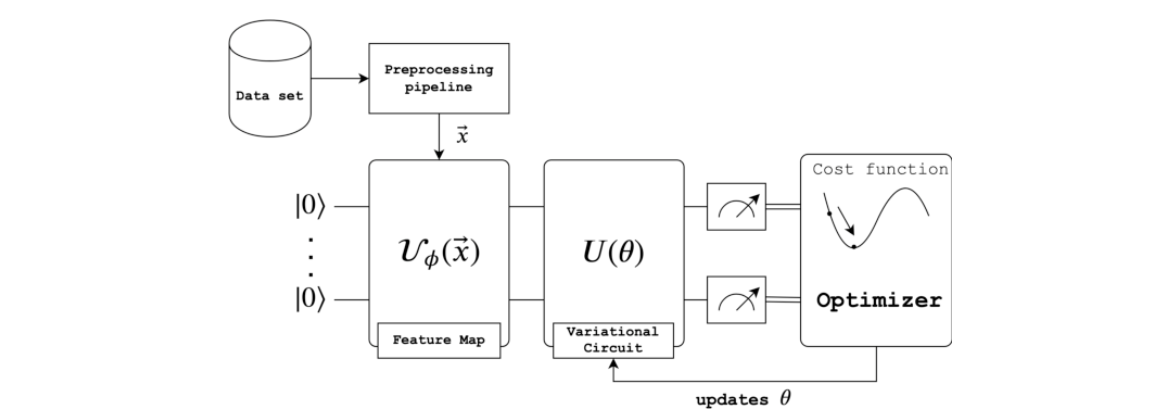

In this tutorial, we will build a quantum machine learning algorithm that classifies and recognizes handwritten digits(whether a digit is 0 or 1) present in the MNIST dataset. We will make use of several dimensional reduction techniques, perform classical pre-processing and initialize our own quantum feature maps.

In [2]:
import time
import numpy as np
import pandas as pd
import seaborn as sns

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [3]:
# # load qsvm libraries
# from qiskit import BasicAer
# from qiskit.aqua import QuantumInstance, aqua_globals
# # from qiskit.aqua.components.feature_maps import SecondOrderExpansion
# from qiskit.aqua.components.multiclass_extensions import (ErrorCorrectingCode,AllPairs,OneAgainstRest)
# from qiskit.aqua.algorithms import QSVM
# from qiskit.aqua.utils import get_feature_dimension
# # from qiskit.aqua.components.feature_maps import SecondOrderExpansion

# # alternative
# feature_map = ZZFeatureMap(num_qubits, reps=2) # Where num_qubts is the number of qubits being used.

---

### Step One : Download the dataset and load the data

https://www.kaggle.com/oddrationale/mnist-in-csv

In [4]:
from qiskit.aqua.components.feature_maps import FeatureMap, RawFeatureVector

/opt/conda/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


In [5]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from qiskit import *
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQC

In [6]:
os.chdir('./VQC/')
os.listdir()

['.ipynb_checkpoints',
 'VariationalQuantumClassifier_01.ipynb',
 'ibm_vqc_mnist_test.csv',
 'ibm_vqc_mnist_train.csv']

In [7]:
os.chdir('../')
os.getcwd()

'/home/jovyan'

#### Structure of the training dataset

- The MNIST dataset has a total of  60,000 data points (rows in train_data) corresponding to digits ranging from 0 to 9
- The first column has the label of the datapoint ranging from 0 to 9
- The next 784 columns/features are each a 28x28 pixel grayscale image collapsed into a row
- The dimension of the dataset is 784. Each of these values range from 0 to 275 where 0 corresponds to white and 255 corresponds to black and any value between 0 and 275 corresponds to a color which is a mix of black and white.
- The testing dataset has the same form except it has 10000 data points. In order to get an idea of a picture of a digit inside the dataset, we will run the following code.

In [8]:
image_size = 28 # width and length are equal
data_path = os.path.join(os.getcwd(), "VQC/")
print(data_path, os.listdir(data_path))

train_data = np.loadtxt(os.path.join(data_path, "ibm_vqc_mnist_train.csv"), delimiter=",", skiprows=1)
test_data = np.loadtxt(os.path.join(data_path + "ibm_vqc_mnist_test.csv"), delimiter=",", skiprows=1)

train_data.shape, test_data.shape

/home/jovyan/VQC/ ['.ipynb_checkpoints', 'VariationalQuantumClassifier_01.ipynb', 'ibm_vqc_mnist_test.csv', 'ibm_vqc_mnist_train.csv']


((12665, 785), (2115, 785))

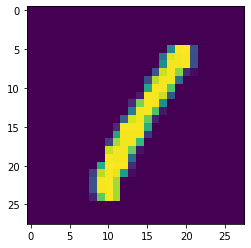

In [9]:
import matplotlib.pyplot as plt
# %matplotlib inline

image = train_data[:, 1:][1].reshape((image_size, image_size))
plt.imshow(image)
plt.show()

In [10]:
train_data_features = train_data[:10000, 1:]
train_data_features[1111].shape

(784,)

In [11]:
train_data_labels = train_data[:10000, :1].reshape(10000,)
train_data_labels.max()

1.0

### Step Two : Apply Dimensionality Reduction Technique

The dimension of the data corresponds to the number of qubits required in order to encode the data for the quantum feature maps we will later initialize. Since quantum computers today can only manipulate 50 qubits, we cannot work with large number of qubits like 784, therefore encoding data with dimension 784 is not viable.

Therefore, we will have to make use of the truncated Singular Value Decomposition (SVD) and t-distributed stochastic neighbor embedding (t-SNE) methods to reduce the dimension down to 10 and then to 2. If you're interested in learning about dimensionality reduction for the MNIST dataset you can read Colah's blog.

We will first truncate the dataset to 10000 data points so that it becomes easier to apply the TruncatedSVD and TSNE techniques.

In [12]:
%%time

#Extracting features and labels from the dataset and truncating the dataset to 10,000 datapoints
train_data_features = train_data[:10000, 1:]
train_data_labels = train_data[:10000, :1].reshape(10000,)

# Using SVD to reduce dimensions to 10
tsvd = TruncatedSVD(n_components=10)
X_SVD = tsvd.fit_transform(train_data_features)

# Use t-SNE technique to reduce dimensions to 2
np.random.seed(0)
tsne = TSNE(n_components=2)
train_data_features_reduced = tsne.fit_transform(X_SVD)

CPU times: user 3min 58s, sys: 6.1 s, total: 4min 4s
Wall time: 53.5 s


We will plot out the dataset to see if there is some sort of clustering due to classification of digits in the reduced dataset. We will need to create a pandas dataframe and using seaborn to plot the data.

In [13]:
# function to help plot the 2-D dataset
def plotdataset(X, Y, c1, c2, N):
    lbl1 = f'Component {c1}'
    lbl2 = f'Component {c2}'    
    df = pd.DataFrame({lbl1:X[:N,c1], lbl2:X[:N,c2], 'label':Y[:N]})
    sns.lmplot(data=df, x=lbl1, y=lbl2, fit_reg=False, hue='label', scatter_kws={'alpha':0.5})

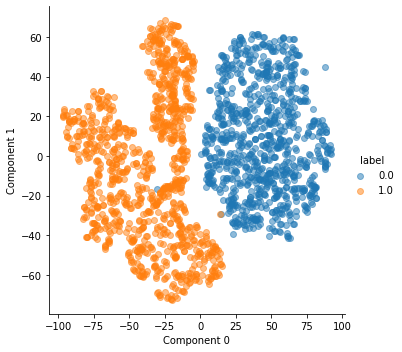

In [14]:
plotdataset(train_data_features_reduced, train_data_labels, 0, 1, N=2000)

### Step Three : Extracting and Normalizing Data

We will extract data points corresponding to the digits 0 and 1 from the reduced dataset and normalize their features to be between 0 and 2.

We need to normalize the data because the values will be inserted into a quantum feature map.

In [15]:
zero_datapoints_array = [] #an array of the data points containing value 0
one_datapoints_array = []# an array of the data points containing value 1
for i in range(10000):
    if train_data_labels[i] == 0:                   # extracting zeros
        zero_datapoints_array.append(train_data_features_reduced[i])

for i in range(10000):
    if train_data_labels[i] == 1:                   # extracting ones
        one_datapoints_array.append(train_data_features_reduced[i])
        
zero_datapoints_array = np.array(zero_datapoints_array)
one_datapoints_array = np.array(one_datapoints_array)

def normalize(arr, max_val, n):
    a = np.divide(arr, max_val)
    return a + n

zero_datapoints_normalized = normalize(zero_datapoints_array, 100, 1)
one_datapoints_normalized = normalize(one_datapoints_array, 100, 1)

### Step Four: Variational Quantum Classifier

We will follow the Variational Quantum Classifier (VQC) method as proposed in the paper [Havlicek](https://arxiv.org/abs/1804.11326) et.al to classify the digits using the concepts of quantum mechanics.

Similar to classical supervised machine learning algorithms, the VQC has a training stage (where data points with labels are provided and learning takes place) and a testing stage (where new data points without labels are provided which are then classified).

The main steps of this algorithm are:

1. Load Data onto the Quantum Computer by Applying a Quantum Feature Map Φ(x)‍

2. Build and apply short-depth Variational Circuit W(θ).

The Quantum Feature Map of depth d is implemented by the following circuit.

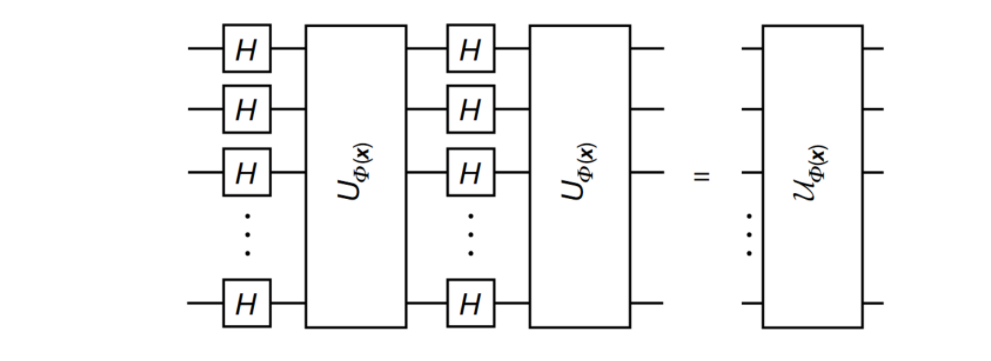

### Step Five : Implementing the Quantum Feature Map

Terra Circuit Library

We will first learn how to configure inbuilt quantum feature maps in Qiskit Terra (Circuit Library) and then how to build a custom feature map. A feature map is a variational circuit.

Some of the feature maps include:

- ZFeatureMap
- ZZFeatureMap
- PauliFeatureMap

Let us first import the required libraries. We will test out the PauliFeatureMap first with

paulis=['Z', 'Y', 'ZZ']

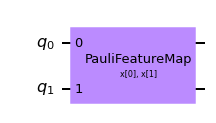

In [16]:
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap
feature_dim = 2
pauli_feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=1, paulis = ['Z','X','ZY'])
pauli_feature_map.draw()

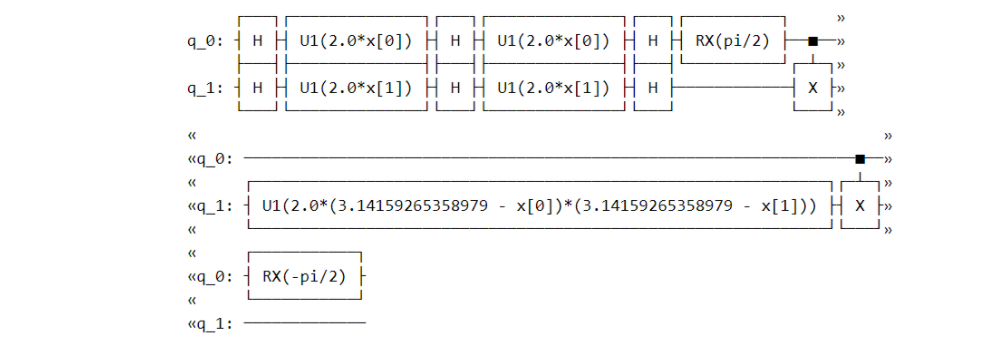

These are the feature maps present in Qiskit. However, these feature maps may not perform well on all datasets. For a particular dataset, finding a quantum feature map that can spread the data points in Hilbert space in such a way that a hyperplane can be drawn to classify them is important to gain higher accuracies for our model(this is the basics of support vector machines).

We also want that the corresponding quantum feature map circuit is shallow( have a small circuit depth) as this reduces quantum decoherence, leading to higher accuracies. If you are interested in learning about errors, decoherence and error mitigation techniques, you can look at this [section](https://qiskit.org/textbook/ch-quantum-hardware/index-circuits.html) of the Qiskit textbook.

Generally, we want to construct custom feature maps for increasing the accuracy of classification.

#### Appending a Variational Quantum Circuit

In this step we will append a variational circuit to the feature map. The parameters of this variational circuit are  trained using classical optimizers until it classifies the data points correctly. This is the training stage of the algorithm and accuracy of the model depends on the variational circuit one chooses.

Constructing using [Real Amplitudes](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html):

Let us create a variational circuit using the inbuilt Real Amplitudes method. Check out the [documentation](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) page to understand how Real Amplitudes work.

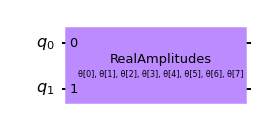

In [17]:
from qiskit.circuit.library import RealAmplitudes, EfficientSU2

num_qubits = 2

variational_circ = RealAmplitudes(num_qubits, entanglement='full', reps=3)
variational_circ.draw()

In [18]:
# # We can also use the EfficentSU2 method to create the variational circuit.
# var_circuit = EfficientSU2(feature_dim, reps=2)

# var_circuit.draw()

### Custom Feature Maps

The following steps need to be done in order to create a custom feature map:

1. Create a ParameterVector object which stores the list of Parameters
2. Create QuantumCircuit object
3. Iterative over the number of qubits and add the gates.

"How" a custom feature map is created is still not clear and in research.

<ipython-input-19-a990b255fb9f>:16: DeprecationWarning: The QuantumCircuit.u1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.p method instead, which acts identically.
  custom_circ.u1(x[i] * x[j], j)


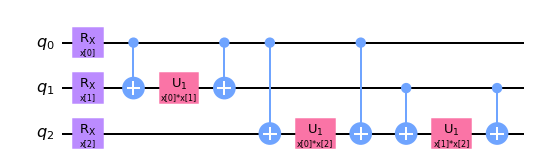

In [19]:
from qiskit.circuit import QuantumCircuit, ParameterVector

num_qubits = 3            
iter = 1              # number of times you'd want to repeat the circuit

x = ParameterVector('x', length=num_qubits)  # creating a list of Parameters
custom_circ = QuantumCircuit(num_qubits)

# defining our parametric form
for _ in range(iter):
    for i in range(num_qubits):
        custom_circ.rx(x[i], i)
    for i in range(num_qubits):
        for j in range(i + 1, num_qubits):
            custom_circ.cx(i, j)
            custom_circ.u1(x[i] * x[j], j)
            custom_circ.cx(i, j)
            
custom_circ.draw()

### Step Six : Performing the Classification Task

Let's apply the VQC method in Qiskit Aqua to solve the task of classifying digits 0 and 1.  We will take a very small subset of 20 training datapoints and 10 testing datapoints. We also keep 5 points per label as a validation set. We will first define the training and testing inputs based on the dataset we initialized before.

In [20]:
train_size = 20
test_size = 10
dp_size_zero = 5
dp_size_one = 5

zero_train = zero_datapoints_normalized[:train_size]
one_train = one_datapoints_normalized[:train_size]

zero_test = zero_datapoints_normalized[train_size + 1:train_size + test_size + 1]
one_test = one_datapoints_normalized[train_size + 1:train_size + test_size + 1]

training_input = {'A':zero_train, 'B':one_train}
test_input = {'A':zero_test, 'B':one_test}

# datapoints is our validation set
datapoints = []
dp_zero = zero_datapoints_normalized[train_size + test_size + 2:train_size + test_size + 2 + dp_size_zero]
dp_one = one_datapoints_normalized[train_size + test_size + 2:train_size + test_size + 2 + dp_size_one]
datapoints.append(np.concatenate((dp_zero, dp_one)))
dp_y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
datapoints.append(dp_y)

class_to_label = {'A': 0, 'B': 1}

### Instantiate the Feature Map

We have not used a custom feature map in this implementation, however the custom feature map we defined before will still work and you can try out different combinations of parameters to see which feature map gives highest accuracy.

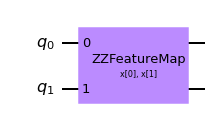

In [21]:
# instantiate feature map

seed = 10598
feature_dim = zero_train.shape[1]

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
feature_map.draw()

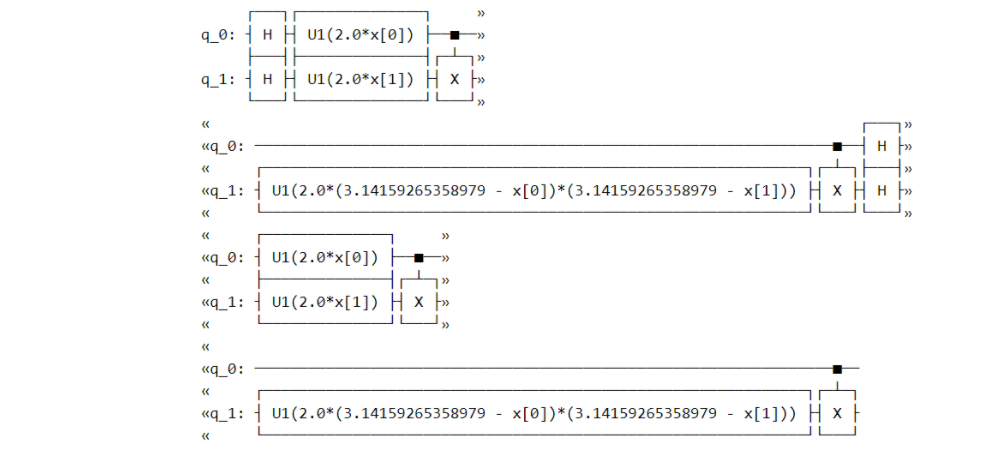

### Instantiate the Classical Optimizer

A classical optimization routine changes the values of our variational circuit and repeats the whole process again. This is the classical loop that trains our parameters until the cost function value decreases. You can look at the [code](https://github.com/Qiskit/qiskit-aqua/blob/master/qiskit/aqua/algorithms/classifiers/vqc.py) and the [optimization step](https://github.com/Qiskit/qiskit-aqua/blob/f5efe642f6374da45b96c5a73a9a01121f95081e/qiskit/aqua/algorithms/classifiers/vqc.py#L661) as given in the Qiskit Textbook to understand the classical optimization process.

VQC Aqua provides a few classical optimizer methods:

- COBYLA - Constrained Optimization By Linear Approximation optimizer.
- SPSA - Simultaneous Perturbation Stochastic Approximation (SPSA) optimizer.
- SLSQP - Sequential Least SQuares Programming optimizer

We will use the COBYLA optimizer method


In [22]:
# Instantiate the Classical Optimizer
from qiskit.aqua.components.optimizers import COBYLA

cobyla = COBYLA(maxiter=500, tol=0.001)
cobyla.print_options

/opt/conda/lib/python3.8/site-packages/qiskit/aqua/components/optimizers/optimizer.py:49: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.components.optimizers',


<bound method Optimizer.print_options of <qiskit.aqua.components.optimizers.cobyla.COBYLA object at 0x7f945c5e1df0>>

### Instantiate the Variational Circuit

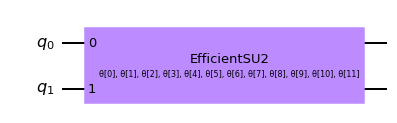

In [23]:
# Instantiate the Variational Circuit
from qiskit.circuit.library import EfficientSU2, RealAmplitudes

var_circuit = EfficientSU2(feature_dim, reps=2)
var_circuit.draw()

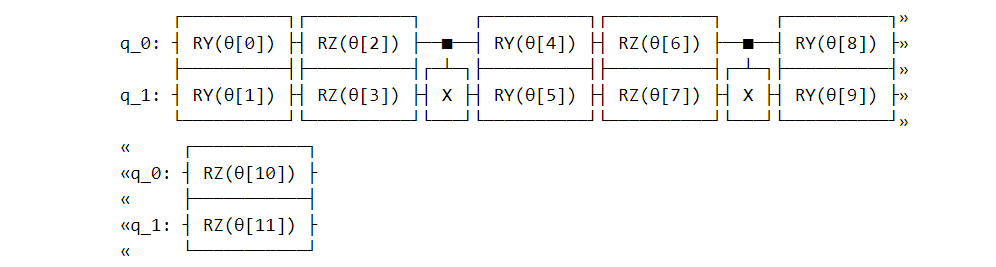

#### Executing the circuit and running it on a Qasm simulator

In [24]:
%%time

# initilizing backend
backend = BasicAer.get_backend('qasm_simulator')
backend_options = {"method": "statevector"}

# creating a quantum instance
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed, backend_options=backend_options)

#initilizing VQC object
# vqc = VQC(optimizer=cobyla, feature_map=feature_map, var_form=var, callback=call_back_vqc, training_dataset=training_input, 
#          test_dataset=test_input, datapoints=datapoints[0])

# var_form=var, callback=call_back_vqc, 
vqc = VQC(optimizer=cobyla, feature_map=feature_map, var_form=var_circuit, training_dataset=training_input, 
         test_dataset=test_input, datapoints=datapoints[0])


CPU times: user 4.59 ms, sys: 15 µs, total: 4.6 ms
Wall time: 4.3 ms


/opt/conda/lib/python3.8/site-packages/qiskit/aqua/quantum_instance.py:135: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_class('aqua.QuantumInstance',
/opt/conda/lib/python3.8/site-packages/qiskit/aqua/algorithms/classifiers/vqc.py:96: DeprecationWarning: The package qiskit.aqua.algorithms.classifiers is deprecated. It was moved/refactored to qiskit_machine_learning.algorithms.classifiers (pip install qiskit-machine-learning). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.classifiers',
/opt/conda/lib/python3.8/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:70: DeprecationWarning: The class qiskit.aqua.algorithms.VQAlgorithm is deprecated. It was moved/refactored to qiskit.algori

In [25]:
vqc

### Step Seven : Measure the Classification Accuracy

In [ ]:
result = vqc.run(quantum_instance)

print("testing accuracy: {}".format(result['testing_accuracy']))
print("prediction of datapoints:")
print("Actual: {}".format(map_label_to_class_name(datapoints[1], vqc.label_to_class)))
print("prediction:   {}".format(result['predicted_classes']))

/opt/conda/lib/python3.8/site-packages/qiskit/aqua/algorithms/quantum_algorithm.py:46: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  return aqua_globals.random
/opt/conda/lib/python3.8/site-packages/qiskit/ml/__init__.py:40: DeprecationWarning: The package qiskit.ml is deprecated. It was moved/refactored to qiskit_machine_learning (pip install qiskit-machine-learning). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('ml', 'qiskit_machine_learning', 'qiskit-machine-learning')


If you run this, then the testing accuracy output is 1.0. This means that our Variational Quantum Circuit is 100% accurate. We can check this by printing the actual and predicted values and we see that wherever there is a 0 in the actual dataset, we have predicted a 0 and vice-versa.